# Intro

Goal of this notebook: 
- familiarising myself with gamma parametrisation. 

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import GammaRegressor

# Gamma Summary

For reference: https://en.wikipedia.org/wiki/Gamma_distribution.

The numpy package's shape and scale parameter are the first parameter set, so $k$ and $\theta$. Mean is $k \theta$. 

# Generate Data

Goal is to visualise different gammas that share the same mean. 

In [2]:
gamma_mean = 10000
number_of_sample = 10000

In [11]:
shape = 1
scale = gamma_mean/shape
df1 = pd.DataFrame.from_dict({'target': np.random.gamma(shape, scale, number_of_sample), 'shape': shape})

In [12]:
shape = 5
scale = gamma_mean/shape
df2 = pd.DataFrame.from_dict({'target': np.random.gamma(shape, scale, number_of_sample), 'shape': shape})

In [13]:
shape = 10
scale = gamma_mean/shape
df3 = pd.DataFrame.from_dict({'target': np.random.gamma(shape, scale, number_of_sample), 'shape': shape})

In [14]:
shape = 20
scale = gamma_mean/shape
df4 = pd.DataFrame.from_dict({'target': np.random.gamma(shape, scale, number_of_sample), 'shape': shape})

In [15]:
df = pd.concat([df1,df2,df3,df4], axis = 0).reset_index()

# Visualisation

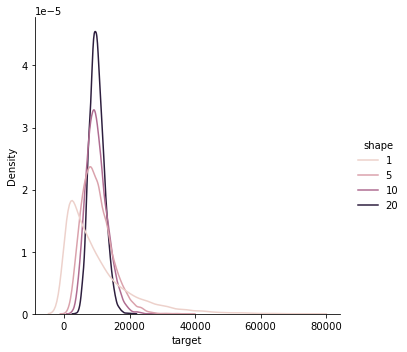

In [16]:
sns.displot(data = df, x = 'target', hue = 'shape', kind = 'kde')
plt.show()

# Distribution Fitting

## Method of Moments

The formula is quite simple, based on observed variance and mean. 

In [17]:
np.mean(df1.target)

9983.503435554676

In [18]:
(np.std(df1.target)) ** 2

99873730.02015181

In [19]:
estimated_shape = np.mean(df1.target) **  2 / (np.std(df1.target)) ** 2
estimated_shape

0.997963536834173

In [20]:
estimated_scale = (np.std(df1.target)) ** 2 / np.mean(df1.target)
estimated_scale

10003.875960463663

In [21]:
estimated_mean = estimated_shape * estimated_scale
estimated_mean

9983.503435554678

In [22]:
estimated_variance = estimated_shape * estimated_scale ** 2
estimated_variance

99873730.02015182

OK, so this method seems to work. 

However, this is not the MLE estimation, MLE should be biased for gamma. 

## Maximum Likelihood Estimation

https://en.wikipedia.org/wiki/Gamma_distribution#Maximum_likelihood_estimation

There is no closed formula, just an approximation. 

In [23]:
def get_gamma_mle_scale(mle_shape, sample):
    # returns the estimated scale parameter, which is dependent on the estimated shape
    return np.mean(sample) / mle_shape

def get_gamma_approximate_mle_shape(sample):
    # returns an approximation of shape parameter
    s = np.log(np.mean(sample)) - np.mean(np.log(sample))
    return (3 - s + ((s-3)**2 + 24 * s) ** 0.5) / (12 * s)

In [24]:
mle_estimated_shape = get_gamma_approximate_mle_shape(df1.target)
mle_estimated_shape

0.9703761471187989

In [25]:
mle_estimated_scale = get_gamma_mle_scale(mle_estimated_shape, df1.target)
mle_estimated_scale

10288.281987554295

In [26]:
mle_estimated_shape * mle_estimated_scale

9983.503435554676

OK, so we get the expected value right (of course, because that is how the scale is set), just not the shape parameter itself.

In [27]:
mle_estimated_shape * mle_estimated_scale**2

102713098.5687036

The variance of the estimated is a bit higher than the actual. 

# GLM - Sklearn

## Baseline

Let's see if we can fit the expected value. 

In [28]:
df1['dummy_feature'] = 1
mdl = GammaRegressor(alpha = 0)
mdl.fit(df1[['dummy_feature']], df1['target'])
df1['pred'] = mdl.predict(df1[['dummy_feature']])
df1.pred[0]

9983.503435554683

## Linear Increase in Shape

We need a new data, this time, we'll have a continuous feature. 

Expected value: feature_1 / 1000 * 20

In [29]:
df_mdl = pd.DataFrame.from_dict({'feature_1' : np.repeat(range(1000,10001),100)})

df_mdl['shape'] = df_mdl['feature_1'] / 1000
df_mdl['scale'] = 20

df_mdl['claim_amount'] = np.random.gamma(shape = df_mdl['shape'], scale = df_mdl['scale'])
df_mdl['log_feature_1'] = np.log(df_mdl['feature_1'])

In [30]:
df_mdl['expected_value'] = df_mdl['shape'] * df_mdl['scale']

In [31]:
mdl = GammaRegressor(alpha = 0)
X = df_mdl[['log_feature_1']]
y = df_mdl['claim_amount']
mdl.fit(X, y)
df_mdl['pred_claim_amount'] = mdl.predict(X)

In [32]:
df_mdl.sample(5)

,feature_1,shape,scale,claim_amount,log_feature_1,expected_value,pred_claim_amount
620071,7200,7.200,20,107.923780,8.881836,144.00,143.994502
576928,6769,6.769,20,164.581054,8.820109,135.38,135.358699
789706,8897,8.897,20,141.819417,9.093469,177.94,178.005922
206130,3061,3.061,20,56.816208,8.026497,61.22,61.116654
10791,1107,1.107,20,26.325796,7.009409,22.14,22.059267


In [33]:
mdl.coef_

array([1.00193063])

## Linear Increase in Scale

In [34]:
df_mdl = pd.DataFrame.from_dict({'feature_1' : np.repeat(range(1000,10001),100)})

df_mdl['scale'] = df_mdl['feature_1'] / 1000
df_mdl['shape'] = 20

df_mdl['claim_amount'] = np.random.gamma(shape = df_mdl['shape'], scale = df_mdl['scale'])
df_mdl['log_feature_1'] = np.log(df_mdl['feature_1'])

In [35]:
df_mdl['expected_value'] = df_mdl['shape'] * df_mdl['scale']

In [36]:
mdl = GammaRegressor(alpha = 0)
X = df_mdl[['log_feature_1']]
y = df_mdl['claim_amount']
mdl.fit(X, y)
df_mdl['pred_claim_amount'] = mdl.predict(X)

In [37]:
df_mdl.sample(5)

,feature_1,scale,shape,claim_amount,log_feature_1,expected_value,pred_claim_amount
582630,6826,6.826,20,111.037102,8.828494,136.52,136.531739
804890,9048,9.048,20,196.492722,9.110299,180.96,180.987057
329599,4295,4.295,20,90.120579,8.365207,85.90,85.898415
604401,7044,7.044,20,143.820293,8.859931,140.88,140.893112
597444,6974,6.974,20,88.086301,8.849944,139.48,139.492668


In [38]:
mdl.coef_

array([1.00022542])

## Constant Mean, but Changing Parameters

Main question: will GLM realise that the expected value remains constant if we increase one parameter and decrease the other? 

In [39]:
expected_value = 1000

df_mdl = pd.DataFrame.from_dict({'feature_1' : np.repeat(range(1000,10001),100)})

df_mdl['scale'] = df_mdl['feature_1'] / 1000
df_mdl['shape'] = expected_value / df_mdl['scale']

df_mdl['claim_amount'] = np.random.gamma(shape = df_mdl['shape'], scale = df_mdl['scale'])
df_mdl['log_feature_1'] = np.log(df_mdl['feature_1'])

In [40]:
df_mdl['expected_value'] = df_mdl['shape'] * df_mdl['scale']

In [41]:
mdl = GammaRegressor(alpha = 0)
X = df_mdl[['log_feature_1']]
y = df_mdl['claim_amount']
mdl.fit(X, y)
df_mdl['pred_claim_amount'] = mdl.predict(X)

In [42]:
df_mdl.sample(5)

,feature_1,scale,shape,claim_amount,log_feature_1,expected_value,pred_claim_amount
683456,7834,7.834,127.648711,1000.306546,8.966229,1000.0,999.943717
431936,5319,5.319,188.005264,1078.337376,8.579041,1000.0,999.943717
530442,6304,6.304,158.629442,977.362455,8.748940,1000.0,999.943717
144374,2443,2.443,409.332788,986.139408,7.800982,1000.0,999.943717
20104,1201,1.201,832.639467,1008.989318,7.090910,1000.0,999.943717


In [43]:
mdl.coef_

array([0.])

## Shape and Scale Tied to Different Features

In [44]:
number_of_sample = 10000

In [45]:
df_mdl = pd.DataFrame.from_dict({'feature_1' : np.random.uniform(low = 1, high = 10, size = number_of_sample),
                                'feature_2' : np.random.uniform(low = 1000, high = 10000, size = number_of_sample)})

In [46]:
df_mdl['shape'] = df_mdl['feature_1']
df_mdl['scale'] = df_mdl['feature_2']

df_mdl['log_feature_1'] = np.log(df_mdl['feature_1'])
df_mdl['log_feature_2'] = np.log(df_mdl['feature_2'])

df_mdl['claim_amount'] = np.random.gamma(shape = df_mdl['shape'], scale = df_mdl['scale'])

In [47]:
df_mdl['expected_value'] = df_mdl['shape'] * df_mdl['scale']

In [48]:
mdl = GammaRegressor(alpha = 0)
X = df_mdl[['log_feature_1', 'log_feature_2']]
y = df_mdl['claim_amount']
mdl.fit(X, y)
df_mdl['pred_claim_amount'] = mdl.predict(X)

In [49]:
df_mdl.sample(5)

,feature_1,feature_2,shape,scale,log_feature_1,log_feature_2,claim_amount,expected_value,pred_claim_amount
6721,9.320469,8726.002338,9.320469,8726.002338,2.232213,9.074063,61964.057696,81330.433768,80766.267253
2965,2.749151,2940.438002,2.749151,2940.438002,1.011292,7.986314,4826.932420,8083.708724,8208.021831
2766,6.938483,4052.003548,6.938483,4052.003548,1.937083,8.306967,17769.748810,28114.756973,28104.819813
520,9.084998,3040.939487,9.084998,3040.939487,2.206624,8.019922,25661.742183,27626.927999,27517.540490
6781,2.813952,3548.006882,2.813952,3548.006882,1.034590,8.174141,23604.639698,9983.921359,10129.009939


In [50]:
mdl.coef_

array([0.9839826 , 0.99754898])

## Summary

Behaved as expected on all test cases. Which is good. 

# GLM - Statsmodels

Trying to decypher why we predict the mean value. Can we individually predict shape and scale...? 

Check out note: https://stackoverflow.com/questions/64174603/how-to-use-scale-and-shape-parameters-of-gamma-glm-in-statsmodels